# ML-Agents Q-Learning with GridWorld

Q-Learning 모델로 ML-Agents의 GridWorld 환경에서 학습  
[Q-Learning with a UnityEnvironment](https://colab.research.google.com/github/Unity-Technologies/ml-agents/blob/release_19_docs/colab/Colab_UnityEnvironment_2_Train.ipynb)을 클론 코딩함으로써 Unity ML-Agents python low level api와 Deep Reinforcement Learning (DRL)에 대한 실습을 진행함.


<img src="https://github.com/Unity-Technologies/ml-agents/blob/release_19_docs/docs/images/gridworld.png?raw=true" align="middle" width="435"/>

## Train the GridWorld Environment with Q-Learning

### What is the  GridWorld Environment

[GridWorld](https://github.com/Unity-Technologies/ml-agents/blob/release_19_docs/docs/Learning-Environment-Examples.md#gridworld) Environment는 간단한 Unity Visual environment이다. Agent는 파란색 사각형이며 3x3 grid내에서 red `x`를 피하면서 green `+`에 도달하는것을 목표로 한다.

observation은 image로 grid의 위에서 카메라에 의해 획득된다.

Action은 5개 중 하나이다.

* Do not move
* Move up
* Move down
* Move right
* Move left

Agent는 green `+`에 도달하면 1.0의 reward를 획득한다. red `x`에 도달 시 -1의 패널티를 획득한다. 또한 각 step마다 -0.01의 패널티가 부여된다.

> **Note** There are 9 Agents, each in their own grid, at once in the environment. This allows for faster data collection.

### The Double Q-Learning Algorithm

Double Q-Learning 알고리즘을 구현하기 위해 먼저 [pytorch](https://pytorch.org/)를 사용해 Deep Q Network(DQN)을 만들었다.  
아래는 입력으로 이미지를 처리하는 매우 간단한 DQN인 `VisualQNetwork` class이다.

In [7]:
import torch
import torch.nn as nn
from typing import Tuple
from math import floor
from torch.nn import Parameter

class VisualQNetwork(torch.nn.Module):
    """image를 학습하는 매우 간단한 visual neural"""
    
    def __init__(self, input_shape: Tuple[int, int, int], encoding_size: int, output_size: int):
        """image batch (3 dimensional tensors)를 입력으로 사용하는 neural network를 생성한다.

        Args:
            input_shape (Tuple[int, int, int]): channel, height, width
            encoding_size (int): fully connected layer의 encoding size
            output_size (int): ouput size
        """
        
        super(VisualQNetwork, self).__init__()
        
        height = input_shape[1]
        width = input_shape[2]
        initial_channels = input_shape[0]
        conv_1_hw = self.conv_output_shape((height, width), 5, 2)
        conv_2_hw = self.conv_output_shape(conv_1_hw, 5, 2)
        conv_3_hw = self.conv_output_shape(conv_2_hw, 5, 2)
        
        self.final_flat = conv_3_hw[0] * conv_3_hw[1] * 32 # flatten된 conv2 ouput tensor의 size: height * width * out_channels
        # self.conv1 = torch.nn.Conv2d(initial_channels, 16, [8, 8], [4, 4])
        # self.conv2 = torch.nn.Conv2d(16, 32, [4, 4], [2, 2])
        # self.dense1 = torch.nn.Linear(self.final_flat, encoding_size)
        # self.dense2 = torch.nn.Linear(encoding_size, output_size)
        
        self.image_layer = nn.Sequential(
            nn.Conv2d(initial_channels, 16, kernel_size=5, stride=2),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=5, stride=2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=5, stride=2),
            nn.BatchNorm2d(32)
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(self.final_flat, encoding_size),
            nn.ReLU(),
            nn.Linear(encoding_size, output_size)
        )
        
        self.value = nn.Sequential(
            nn.Linear(self.final_flat, encoding_size),
            nn.ReLU(),
            nn.Linear(encoding_size, 1)
        )
        
        # self.fc_layer = nn.Sequential(
        #     nn.Linear(self.final_flat, encoding_size),
        #     nn.ReLU(),
        #     nn.Linear(encoding_size, output_size)
        # )
        
    def forward(self, visual_obs: torch.Tensor):      
        out = self.image_layer(visual_obs)
        out = out.reshape([-1, self.final_flat]) # flatten and input to the fully connected layer
        advantage = self.advantage(out)
        value = self.value(out)
        
        return value + advantage - advantage.mean()
        
    
    @staticmethod
    def conv_output_shape(h_w: Tuple[int, int], kernel_size: int = 1, stride: int = 1, pad: int = 0, dilation: int = 1):
        """convolution layer의 출력의 height과 width를 반환한다."""
        
        h = floor(
            ((h_w[0] + (2 * pad) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        )
        w = floor(
            ((h_w[1] + (2 * pad) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        )
        return h, w
        

Q-Learning을 학습시키는데 사용할 data를 저장하기 위한 data type을 정의한다. ReplayBuffer에 쓰인다.

In [8]:
import numpy as np
from typing import NamedTuple, List

class Experience(NamedTuple):
    """Agent transition data를 포함하는 experience"""
    
    obs: np.ndarray
    action: np.ndarray
    reward: float
    done: bool
    next_obs: np.ndarray
    
# A Trajectory is an ordered sequence of Experiences
Trajectory = List[Experience]

# A Buffer is an unordered list of Experiences from multiple Trajectories
Buffer = List[Experience]

`Trainer` class를 정의한다. `Trainer` class는 policy를 따르는 environment로부터 data를 모은 뒤 2개의 DQN을 학습해 Double Q-learning을 수행한다.

In [9]:
from mlagents_envs.environment import ActionTuple, BaseEnv
from typing import Dict
import random

class DoubleDQNTrainer:
    
    def __init__(self, env: BaseEnv, 
                 default_q_net: VisualQNetwork, 
                 target_q_net: VisualQNetwork, 
                 optimzier: torch.optim,
                 loss_func: torch.nn,
                 device: torch.device):
        """Double DQN Trainer class

        Args:
            env (BaseEnv): The UnityEnvironment used
            default_q_net (VisualQNetwork): The default Q-Network used to collect the data
            target_q_net (VisualQNetwork): The target Q-Network  used to update q-values of the default Q-Network
        """
        self.env = env
        self.default_q_net = default_q_net
        self.target_q_net = target_q_net
        self.optimizer = optimzier
        self.loss_func = loss_func
        self.device = device
        
        self.step = 0
        
    
    def generate_trajectories(self, buffer_size: int, epsilon: float = 0.1):
        """Q-Network로부터 획득된 policy와 함께 주어진 Unity Environment를 실행해 획득된 experience들의 buffer를 생성한다.

        Args:
            buffer_size (int): The minimum size of the buffer this method will return.
            epsilon (float): Will add a random normal variable with standard deviation.
        
        Returns:
            a Tuple containing the created buffer and the average cumulative the Agents obtained.
        """
        
        buffer: Buffer = []
        
        # Reset the environment
        self.env.reset()
        # Environment의 Behavior Name을 저장함
        behavior_name = list(self.env.behavior_specs)[0]
        # Enviornment의 Behavior Specs를 저장함
        spec = self.env.behavior_specs[behavior_name]
        
        # AgentID에서 Trajectories로의 Mapping을 생성. 각 Agent에 대한 trajectories를 생성하기 위해서임.
        dict_trajectories_from_agent: Dict[int, Trajectory] = {}
        # AgentId에서 Agent의 last observation으로의 Mapping을 생성.
        dict_last_obs_from_agent: Dict[int, np.ndarray] = {}
        # AgentID에서 Agent의 last action으로의 Mapping을 생성.
        dict_last_action_from_agent: Dict[int, np.ndarray] = {}
        # AgentID에서 cumulative reward로의 Mapping을 생성.
        dict_cumulative_reward_from_agent: Dict[int, float] = {}
        # 지금까지 획득된 comulative reward를 저장하는 list 생성.
        cumulative_rewards: List[float] = []
        
        # buffer에 데이터가 충분해질때까지 반복
        while len(buffer) < buffer_size:
            # Agent의 Decision Step과 Terminal Step 획득
            decision_steps, terminal_steps = self.env.get_steps(behavior_name)
            
            # tensor를 NHWC에서 NCHW 형태로 변경. 즉, 이미지 tensor 채널을 PyTorch 입력에 맞게 변경함.
            order = (0, 3, 1, 2)
            decision_steps.obs[0] = np.transpose(decision_steps.obs[0], order) #for obs in decision_steps.obs
            terminal_steps.obs[0] = np.transpose(terminal_steps.obs[0], order) #for obs in terminal_steps.obs
            
            # Terminal Step을 가진 모든 Agent에 대해 반복
            for agent_id_terminated in terminal_steps:
                # Agent가 terminated됬기 때문에 last experience를 생성
                last_experience = Experience(
                    obs=dict_last_obs_from_agent[agent_id_terminated].copy(),
                    reward=terminal_steps[agent_id_terminated].reward,
                    done=not terminal_steps[agent_id_terminated].interrupted,
                    action=dict_last_action_from_agent[agent_id_terminated].copy(),
                    next_obs=terminal_steps[agent_id_terminated].obs[0]
                )
                
                # trajectory가 끝났기 때문에 agent의 last observation과 action을 제거함
                dict_last_obs_from_agent.pop(agent_id_terminated)
                dict_last_action_from_agent.pop(agent_id_terminated)
                # cumulative reward를 기록함
                cumulative_reward = dict_cumulative_reward_from_agent.pop(agent_id_terminated) + terminal_steps[agent_id_terminated].reward
                cumulative_rewards.append(cumulative_reward)
                # Trajectory와 last experience를 buffer에 추가
                buffer.extend(dict_trajectories_from_agent.pop(agent_id_terminated))
                buffer.append(last_experience)
            
            # Decision Step을 가진 모든 Agent에 대해
            for agent_id_decisions in decision_steps:
                # Agent가 Trajectory가 없다면 생성
                if agent_id_decisions not in dict_trajectories_from_agent:
                    dict_trajectories_from_agent[agent_id_decisions] = []
                    dict_cumulative_reward_from_agent[agent_id_decisions] = 0
                    
                # decision을 요청하는 Agent가 "last observation"을 가지고 있다면
                if agent_id_decisions in dict_last_obs_from_agent:
                    # last observation으로부터의 Experience와 Decision Step을 생성
                    exp = Experience(
                        obs=dict_last_obs_from_agent[agent_id_decisions].copy(),
                        reward=decision_steps[agent_id_decisions].reward,
                        done=False,
                        action=dict_last_action_from_agent[agent_id_decisions].copy(),
                        next_obs=decision_steps[agent_id_decisions].obs[0]
                    )
                    # Agent의 Trajectory와 cumulative reward를 Update
                    dict_trajectories_from_agent[agent_id_decisions].append(exp)
                    dict_cumulative_reward_from_agent[agent_id_decisions] += decision_steps[agent_id_decisions].reward
                    
                # 새로운 "last observation"을 저장함
                dict_last_obs_from_agent[agent_id_decisions] = decision_steps[agent_id_decisions].obs[0]
                
            # with torch.no_grad():
            #     # decision을 요청한 모든 Agent에 대한 action을 생성
            #     # observation에 대한 각 action value를 계산
            #     q_values = self.default_q_net(torch.from_numpy(decision_steps.obs[0]).to(self.device))
            #     # # noise 추가
            #     q_values += epsilon * torch.randn(q_values.shape[0], q_values.shape[1]).to(self.device)
            #     # best action 선택
            #     actions = torch.argmax(q_values, dim=1)
            actions = self.act(decision_steps.obs[0], epsilon)
            actions = actions.reshape((len(decision_steps), 1))
            # actions = actions.cpu().detach().numpy()
            # 선택된 action들을 저장
            for agent_index, agent_id in enumerate(decision_steps.agent_id):
                dict_last_action_from_agent[agent_id] = actions[agent_index]
        
            # environment 내 action들을 설정
            # Unity Environments는 ActionTuple instance를 사용함
            action_tuple = ActionTuple()
            action_tuple.add_discrete(actions)
            self.env.set_actions(behavior_name, action_tuple)
            # 다음 step으로 진행
            self.step += 1
            self.env.step()
            
        return buffer, np.mean(cumulative_rewards)
    
    def act(self, state: np.ndarray, epsilon: float = 0.1):
        if random.random() > epsilon:
            with torch.no_grad():
                q_values = self.default_q_net(torch.from_numpy(state).to(device=self.device)).cpu().detach().numpy()
                actions = np.argmax(q_values, axis=1)
        else:
            # q_values = np.random.random(state.shape)
            actions = np.random.randint(5, size=1)
        
        return actions

    def update_q_network(self, buffer: Buffer):
        """제공된 buffer로 Q-Network를 update함."""
        
        BATCH_SIZE = 200
        NUM_EPOCH = 2
        GAMMA = 0.90
                
        batch_size = min(len(buffer), BATCH_SIZE)
        random.shuffle(buffer)
        # buffer를 batch size 단위로 split함.
        batches = [buffer[batch_size * start : batch_size * (start + 1)] for start in range(int(len(buffer) / batch_size))]
        loss_avg = 0
        step = 0
        
        for _ in range(NUM_EPOCH):
            for batch in batches:
                # network에 입력될 Tensor를 생성
                obs = torch.from_numpy(np.stack([ex.obs for ex in batch])).to(device=self.device)
                reward = torch.from_numpy(np.array([ex.reward for ex in batch], dtype=np.float32).reshape(-1, 1)).to(device=self.device)
                done = torch.from_numpy(np.array([ex.done for ex in batch], dtype=np.float32).reshape(-1, 1)).to(device=self.device)
                action = torch.from_numpy(np.stack([ex.action for ex in batch])).to(device=self.device)
                next_obs = torch.from_numpy(np.stack(ex.next_obs for ex in batch)).to(device=self.device)
                
                # Q-Network를 update하기 위해 Double Q-learning 알고리즘 사용
                
                q_values = self.default_q_net(obs)
                # next_q_values = self.default_q_net(next_obs)
                next_q_target_values = self.default_q_net(next_obs)
                
                prediction = q_values.gather(1, action)
                # expected_q_values = next_q_target_values.gather(1, torch.argmax(next_q_values, dim=1, keepdim=True))
                expected_q_values = torch.max(next_q_target_values, dim=1, keepdim=True)[0]
                target = reward + (1.0 - done) * GAMMA * expected_q_values
                loss = self.loss_func(prediction, target)
                
                # backpropagation 실행
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                step += 1
                loss_avg += (1 / step) * (loss.cpu().detach().numpy() - loss_avg)
                                
        # if self.step % 2000 == 0:
        #     # for target_param, param in zip(qnet.parameters(), target_qnet.parameters()):
        #     #     target_param.data.copy_(param)
        #     self.update_target_q_net()
        
        return loss_avg
    
    def update_target_q_net(self):
        self.target_q_net.load_state_dict(self.default_q_net.state_dict())

### Run Training

In [10]:
import matplotlib.pyplot as plt

def summary_env(env: BaseEnv):
    print('=' * 100)
    
    env.reset()
    behavior_name = list(env.behavior_specs)[0]
    print(f"Name of the behavior : {behavior_name}")
    spec = env.behavior_specs[behavior_name]
    
    # Examine the number of observations per Agent
    print("Number of observations : ", len(spec.observation_specs))
    
    # Is there a visual observation ?
    # Visual observation have 3 dimensions: Height, Width and number of channels
    vis_obs = any(len(spec.shape) == 3 for spec in spec.observation_specs)
    print("Is there a visual observation ?", vis_obs)
    
    # Is the Action continuous or multi-discrete ?
    if spec.action_spec.continuous_size > 0:
        print(f"There are {spec.action_spec.continuous_size} continuous actions")
    if spec.action_spec.is_discrete():
        print(f"Number of discrete action branches : {spec.action_spec.discrete_size}")
        
    # For discrete actions only : How many different options does each action has ?
    if spec.action_spec.discrete_size > 0:
        for branch, action_size in enumerate(spec.action_spec.discrete_branches):
            print(f"Action branch {branch} has {action_size} different options")
            
    decision_steps, _ = env.get_steps(behavior_name)
    print(f"Number of agents : {len(decision_steps)}")
    
    action_tuple = spec.action_spec.empty_action(len(decision_steps))
    env.set_actions(behavior_name, action_tuple)
    env.step()

    # Print observation spaces
    for index, obs_spec in enumerate(spec.observation_specs):
        if len(obs_spec.shape) == 3:
            print("=== Visual observation ===")
            plt.imshow(decision_steps.obs[index][0,:,:,:])
            plt.show()
    
    for index, obs_spec in enumerate(spec.observation_specs):
        if len(obs_spec.shape) == 1:
            print("=== Vector observation ===")
            print(decision_steps.obs[index][0,:])
            
    print('=' * 100)

GridWorld environment created.
Name of the behavior : GridWorld?team=0
Number of observations :  2
Is there a visual observation ? True
Number of discrete action branches : 1
Action branch 0 has 5 different options
Number of agents : 1
=== Visual observation ===


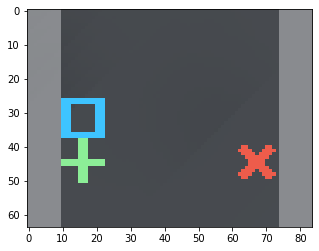

=== Vector observation ===
[1. 0.]


In [11]:
# -----------------
# Unity Environment가 닫혀있지 않았을 경우를 위한 처리
try:
    env.close()
except:
    pass
# -----------------

from mlagents_envs.registry import default_registry
from mlagents_envs.environment import UnityEnvironment
import os
%matplotlib inline

# CridWorl Environment 생성
env_dir = os.pardir + "/Environments/GridWorld"
env = UnityEnvironment(file_name=env_dir)
print("GridWorld environment created.")

summary_env(env)

cuda:0


c:\Users\slem1\anaconda3\envs\ml-agents-release19\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Training step: 1 	reward: -0.9999999776482582	loss: 0.2897700099274516
Training step: 6 	reward: -0.9999999776482582	loss: 0.0003216707460524049

Training interrupted, continue to next cell to save to save the model.


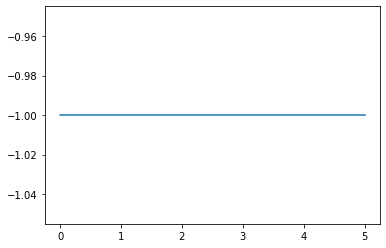

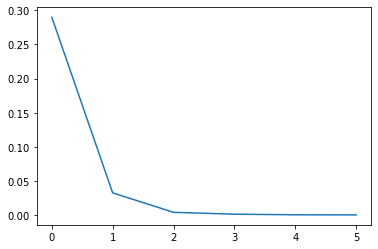

In [12]:
num_actions = 5
learning_rate = 0.001
epsilon = 0.1

try:
    # Q-Network 생성
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    # device = torch.device("cpu")
    
    qnet = VisualQNetwork((3, 64, 84), 126, num_actions).to(device=device)
    target_qnet = VisualQNetwork((3, 64, 84), 126, num_actions).to(device=device)
    
    experiences: Buffer = []
    
    trainer = DoubleDQNTrainer(
        env,
        qnet,
        target_qnet,
        torch.optim.Adam(qnet.parameters(), lr=learning_rate),
        torch.nn.MSELoss(),
        device
    )
    
    trainer.update_target_q_net()
    
    cumulatvie_rewards: List[float] = []
    loss_arr = []
    
    NUM_TRAINING_STEPS = 100 # The number of training steps that will be performed
    NUM_NEW_EXP = 500 # The number of experiences to collect per training step
    BUFFER_SIZE = 2000 # The maximum size of the Buffer
    
    old_range = NUM_TRAINING_STEPS - 0
    new_range = 0.1 - 0.01
    
    for n in range(NUM_TRAINING_STEPS):
        # new_exp, _ = Trainer.generate_trajectories(env, qnet, NUM_NEW_EXP, epsilon=0.1)
        new_exp, _ = trainer.generate_trajectories(NUM_NEW_EXP, epsilon=epsilon)
        experiences.extend(new_exp)
        random.shuffle(experiences)
        if len(experiences) > BUFFER_SIZE:
            experiences = experiences[:BUFFER_SIZE]
        loss = trainer.update_q_network(experiences)
        _, rewards = trainer.generate_trajectories(100, epsilon=0)
        cumulatvie_rewards.append(rewards)
        epsilon = ((n - 0) / old_range * new_range) + 0.01
        loss_arr.append(loss)
        if n % 5 == 0:
            print(f"Training step: {n + 1} \treward: {rewards}\tloss: {loss}")
except KeyboardInterrupt:
    print("\nTraining interrupted, continue to next cell to save to save the model.")
    plt.plot(cumulatvie_rewards)
    plt.show()
    plt.plot(loss_arr)
    plt.show()

finally:
    env.close()

### Export PyTorch Model to ONNX

Unity ML-Agents의 inference에 사용할 model을 추출한다. 이를 위해 다음과 같은 추가적인 tensor가 필요하다.

* All models need version_number
* All models need memory_size
* Models with **continuous outputs** need continuous_action_output_shape
* Models with **discrete outputs** need discrete_action_output_shape and an additional mask input that matches the shape of the discrete outputs
* The mask input must be connected to the outputs or it will be pruned on export, if mask values aren't being set they will be 1, so multiplying the discrete outputs by the mask will have no effect

In [ ]:
class WrapperNet(torch.nn.Module):
    
    def __init__(self, qnet: VisualQNetwork, discrete_ouput_sizes: List[int]):
        """
        runtime inference에 의해 요구되는 여분의 상수들과 
        더미 mask input들을 추가한 VisualQNetwork를 Wraping한다.
        """
        
        super(WrapperNet, self).__init__()
        self.qnet = qnet
        
        # version_number
        #   MLAgents1_0 = 2
        #   MLAgents2_0 = 3
        version_number = torch.Tensor([3])
        self.version_number = Parameter(version_number, requires_grad=False)
        
        # memory_size
        # TODO: document case where memory is not zero.
        memory_size = torch.Tensor([0])
        self.memory_size = Parameter(memory_size, requires_grad=False)
        
        # discrete_action_ouput_shape
        output_shape = torch.Tensor([discrete_ouput_sizes])
        self.discrete_shape = Parameter(output_shape, requires_grad=False)
        
    # discrete action이라면 input으로 같은 shape의 mask tensor를 받는다.
    def forward(self, visual_obs: torch.Tensor, mask: torch.Tensor):
        qnet_result = self.qnet(visual_obs)
        # 제거되는 현상을 막기 위해 mask를 연결
        # WriteDiscreteActionMask() 내에서 SetActionMask()를 호출하지 않을 경우 mask value는 1
        qnet_result = torch.mul(qnet_result, mask)
        action = torch.argmax(qnet_result, dim=1, keepdim=True)
        return [action], self.discrete_shape, self.version_number, self.memory_size
    
torch.onnx.export(
    WrapperNet(qnet, [num_actions]),
    (torch.tensor([experiences[0].obs]), torch.ones(1, num_actions)),
    "GridWorld.onnx",
    opset_version=9,
    input_names=["obs_0", "action_masks"],
    output_names=["discrete_actions", "discrete_action_ouput_shape", "version_number", "memory_size"],
    dynamic_axes={
        "obs_0": {0: "batch"},
        "action_masks": {0: "batch"},
        "discrete_actions": {0: "batch"},
        "discrete_action_ouput_shape": {0: "batch"}
    }
)

## References

[1] [Q-Learning with a UnityEnvironment](https://colab.research.google.com/github/Unity-Technologies/ml-agents/blob/release_19_docs/colab/Colab_UnityEnvironment_2_Train.ipynb)